Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [48]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import glob




In [49]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [50]:
path_to_benign_train = './data/Train'
path_to_benign_test = './data/Test'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [51]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_benign_train)
data_dir_test = pathlib.Path(path_to_benign_test)

In [52]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

Use 80% of the images for training, and 20% for validation.

In [53]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

batch_size = 32
img_height = 180 # This should map with the height and width of the pretrained model
img_width = 180 # This should map with the height and width of the pretrained model


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [54]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [55]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [56]:
# # Keras.preprocessing
# # The 1./255 is to convert from uint8 to float32 in range [0,1].
# image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# BATCH_SIZE = 32 
# # For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
# IMG_HEIGHT = 180 # This should map with the height and width of the pretrained model
# IMG_WIDTH = 180 # This should map with the height and width of the pretrained model
# STEPS_PER_EPOCH = np.ceil(image_count_train/BATCH_SIZE)

# train_data_gen = image_generator.flow_from_directory(directory=str(list(data_dir_train.glob('training'))[0]),
#                                                      batch_size=BATCH_SIZE,
#                                                      shuffle=True,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      classes = list(class_names))

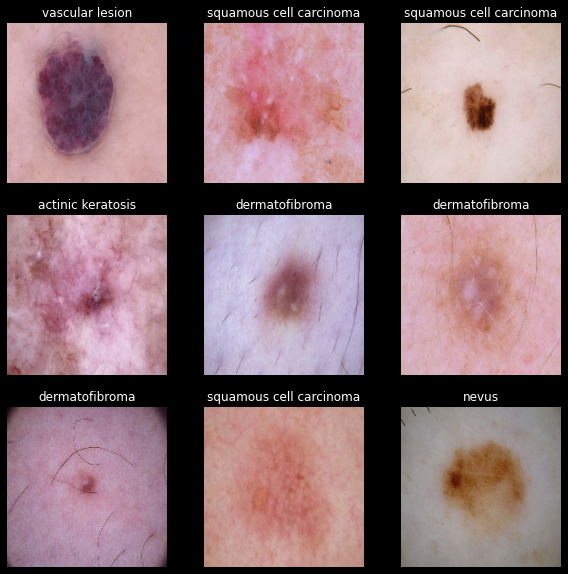

In [57]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [58]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [61]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14509787 0.82843137


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [62]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [63]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [65]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 19s 64ms/step - loss: 1.9738 - accuracy: 0.2439 - val_loss: 1.4099 - val_accuracy: 0.4677
Epoch 2/30
281/281 [==============================] - 6s 22ms/step - loss: 1.3116 - accuracy: 0.5142 - val_loss: 1.1165 - val_accuracy: 0.5759
Epoch 3/30
281/281 [==============================] - 6s 22ms/step - loss: 0.9928 - accuracy: 0.6350 - val_loss: 0.8956 - val_accuracy: 0.6729
Epoch 4/30
281/281 [==============================] - 6s 22ms/step - loss: 0.7815 - accuracy: 0.7146 - val_loss: 0.7028 - val_accuracy: 0.7606
Epoch 5/30
281/281 [==============================] - 6s 22ms/step - loss: 0.5568 - accuracy: 0.8008 - val_loss: 0.6526 - val_accuracy: 0.7953
Epoch 6/30
281/281 [==============================] - 6s 22ms/step - loss: 0.4272 - accuracy: 0.8533 - val_loss: 0.5960 - val_accuracy: 0.8069
Epoch 7/30
281/281 [==============================] - 6s 22ms/step - loss: 0.3127 - accuracy: 0.8874 - val_loss: 0.9216 - val_accuracy: 0.715

### Visualizing training results

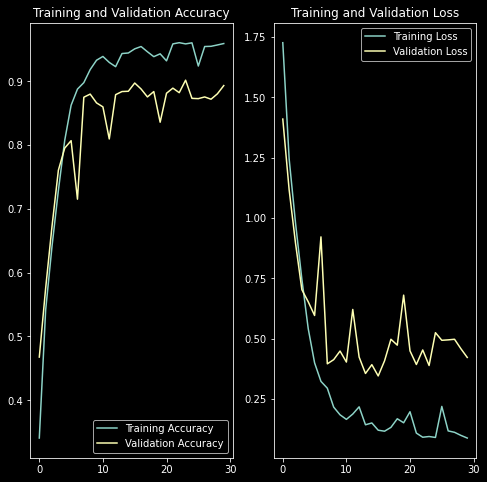

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Validation is getting stuck at 55 percent and the validation loss is at 2.5 all most 

### Write your findings here

In [67]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

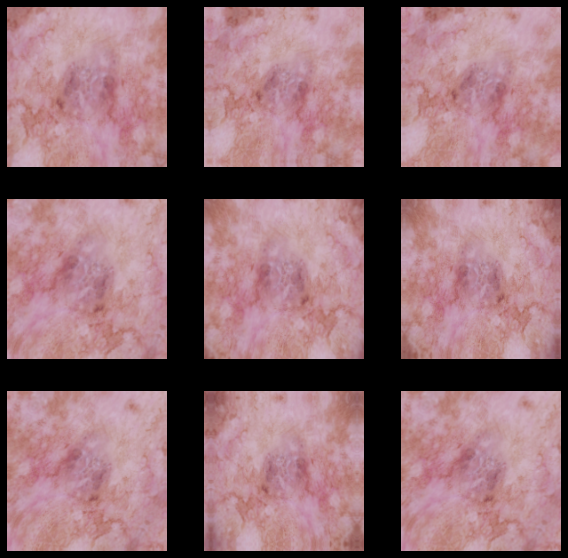

In [68]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [69]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [70]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model2.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 45, 45, 32)       

### Training the model

In [71]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 8s 24ms/step - loss: 1.9910 - accuracy: 0.2136 - val_loss: 1.5727 - val_accuracy: 0.3930
Epoch 2/30
281/281 [==============================] - 7s 24ms/step - loss: 1.5050 - accuracy: 0.4194 - val_loss: 1.3491 - val_accuracy: 0.4722
Epoch 3/30
281/281 [==============================] - 7s 24ms/step - loss: 1.3608 - accuracy: 0.4752 - val_loss: 1.2552 - val_accuracy: 0.5162
Epoch 4/30
281/281 [==============================] - 7s 24ms/step - loss: 1.2730 - accuracy: 0.5230 - val_loss: 1.2172 - val_accuracy: 0.5256
Epoch 5/30
281/281 [==============================] - 7s 24ms/step - loss: 1.2624 - accuracy: 0.5246 - val_loss: 1.1267 - val_accuracy: 0.5777
Epoch 6/30
281/281 [==============================] - 7s 24ms/step - loss: 1.1541 - accuracy: 0.5679 - val_loss: 1.3431 - val_accuracy: 0.5087
Epoch 7/30
281/281 [==============================] - 7s 24ms/step - loss: 1.1209 - accuracy: 0.5742 - val_loss: 1.0034 - val_accuracy: 0.6404

### Visualizing the results

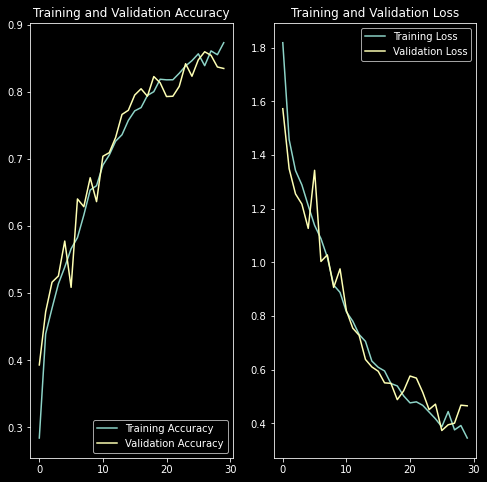

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [73]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
    * seborrheic keratosis
    * vascular lesion
    * dermatofibroma
    * actinic keratosis


#### - Which classes dominate the data in terms proportionate number of samples?



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [74]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [75]:
path_to_training_dataset="/mnt/Data/ML-Course_Work/ML-Study-Upgrad/course/DeepLearning/assignment/data/Train/"
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]Initialised with 114 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7130C50370>: 100%|██████████| 500/500 [00:04<00:00, 110.14 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]basal cell carcinoma
Initialised with 376 image(s) found.
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F70047B85B0>: 100%|██████████| 500/500 [00:04<00:00, 109.06 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7130D48130>:   0%|          | 1/500 [00:00<01:27,  5.73 Samples/s]dermatofibroma
Initialised with 95 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F711C0CF760>: 100%|██████████| 500/500 [00:04<00:00, 116.28 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]melanoma
Initialised with 438 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=1

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [76]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [77]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

nign keratosis/output/pigmented benign keratosis_original_ISIC_0025867.jpg_c9184544-4ab9-4025-a9c0-71233f1a3779.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027435.jpg_7e406df6-2b6f-4a0f-ad84-d5e957a673f7.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025548.jpg_1615adcd-a3d3-432e-9301-7344b1e5e6da.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028020.jpg_54f14b06-8f48-4383-8481-9b1a36ebff73.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025064.jpg_92abed26-5a43-4477-8ee2-b852447e342e.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027680.jpg_2f3ef159-e2df-4669-aa2f-9801780e621d.jpg',
 'data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028497.jpg_8eaaac79-91e8-4357-9f63-dccecd38dcc3.jpg',
 'data/Train/pigmented b

In [78]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [79]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [80]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [81]:
df2['Label'].value_counts()

actinic keratosis             1500
nevus                         1500
melanoma                      1500
dermatofibroma                1500
seborrheic keratosis          1500
pigmented benign keratosis    1500
basal cell carcinoma          1500
squamous cell carcinoma       1500
vascular lesion               1500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [82]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [83]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train= "/mnt/Data/ML-Course_Work/ML-Study-Upgrad/course/DeepLearning/assignment/data"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15857 files belonging to 2 classes.
Using 12686 files for training.


#### **Todo:** Create a validation dataset

In [84]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15857 files belonging to 2 classes.
Using 3171 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [85]:
## your code goes here
num_classes = 9

model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [86]:
## your code goes here
## Your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [87]:
epochs = 50
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
397/397 [==============================] - 205s 506ms/step - loss: 2.9112 - accuracy: 0.9683 - val_loss: 10.3526 - val_accuracy: 0.5393
Epoch 2/50
397/397 [==============================] - 198s 494ms/step - loss: 0.0506 - accuracy: 0.9933 - val_loss: 0.1365 - val_accuracy: 0.9902
Epoch 3/50
397/397 [==============================] - 199s 496ms/step - loss: 0.0412 - accuracy: 0.9935 - val_loss: 0.1255 - val_accuracy: 0.9909
Epoch 4/50
397/397 [==============================] - 203s 507ms/step - loss: 0.0439 - accuracy: 0.9929 - val_loss: 0.1126 - val_accuracy: 0.9909
Epoch 5/50
397/397 [==============================] - 198s 495ms/step - loss: 0.0391 - accuracy: 0.9929 - val_loss: 1.7662 - val_accuracy: 0.9290
Epoch 6/50
397/397 [==============================] - 201s 501ms/step - loss: 0.0422 - accuracy: 0.9932 - val_loss: 0.1503 - val_accuracy: 0.9786
Epoch 7/50
397/397 [==============================] - 199s 496ms/step - loss: 1.0813 - accuracy: 0.9907 - val_loss: 3.8476 

#### **Todo:**  Visualize the model results

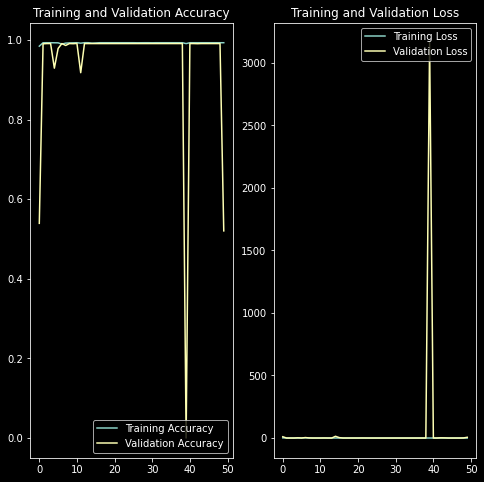

 Accuracy in all epochs ::  [0.984313428401947, 0.9929055571556091, 0.992984414100647, 0.992984414100647, 0.9928267598152161, 0.9926691055297852, 0.9894371628761292, 0.9919596314430237, 0.9924325942993164, 0.9927479028701782, 0.992984414100647, 0.9918019771575928, 0.99306321144104, 0.99306321144104, 0.9919596314430237, 0.9923537969589233, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.9928267598152161, 0.9929055571556091, 0.992984414100647, 0.992984414100647, 0.9928267598152161, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.9907772541046143, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647, 0.992984414100647]
 Validati

In [88]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(" Accuracy in all epochs :: ", acc)
print(" Validation Accuracy in all epochs :: ", val_acc)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



by performing the class rebalance we have reached a validation accuracy quit well


In [89]:

batch_size = 32
img_height = 180 # This should map with the height and width of the pretrained model
img_width = 180 # This should map with the height and width of the pretrained model
#path_to_benign_test

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [90]:
# test with a prediction
import tensorflow as tf


predictions = model3.predict(test_ds)
score = tf.nn.softmax(predictions[100])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

score = tf.nn.softmax(predictions[5])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



This image most likely belongs to actinic keratosis with a 99.99 percent confidence.
This image most likely belongs to actinic keratosis with a 100.00 percent confidence.


In [91]:
!mkdir -p saved_model
model3.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets
